<a href="https://colab.research.google.com/github/w1767/MSc-project/blob/main/VIX_Volatility_15_nov_2021_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Volatility Prediction Using GARCH, Monte Carlo, LSTM, SVM and Random Forest

In [125]:
#pip install -U scikit-learn scipy matplotlib

In [126]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [127]:
!pip install arch
from datetime import datetime, timedelta
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from arch import arch_model
from sklearn.svm import SVR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import os
import glob
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.ensemble import RandomForestRegressor
from keras.models import load_model
from sklearn import metrics

### Reading the dataset from your local directory

In [128]:
#os.chdir('D:\Project') 

In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
path = "/content/drive/MyDrive/Master thesis/VIX.csv"

In [131]:
VI_db=pd.read_csv("/content/drive/MyDrive/Master thesis/VIX.csv")

In [132]:
VI_db.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,02/01/1990,17.240000,17.240000,17.240000,17.240000,17.240000,0
1,03/01/1990,18.190001,18.190001,18.190001,18.190001,18.190001,0
2,04/01/1990,19.219999,19.219999,19.219999,19.219999,19.219999,0
3,05/01/1990,20.110001,20.110001,20.110001,20.110001,20.110001,0
4,08/01/1990,20.260000,20.260000,20.260000,20.260000,20.260000,0


### Data type formating of the required features 

In [133]:
VI_db['Date']= pd.to_datetime(VI_db['Date'])

### Features preparations

In [134]:
VI_db['log_price'] = np.log(VI_db['Close'])

In [135]:
VI_db['pct_change'] = VI_db['log_price'].diff()

In [136]:
VI_db['stdev'] = VI_db['pct_change'].rolling(window=30, center=False).std()

In [137]:
VI_db['Volatility'] = VI_db['stdev']*(252**0.5)

### Display top 100 records

In [138]:
VI_db.head(100)

,Date,Open,High,Low,Close,Adj Close,Volume,log_price,pct_change,stdev,Volatility
0,1990-02-01,17.240000,17.240000,17.240000,17.240000,17.240000,0,2.847232,NaN,NaN,NaN
1,1990-03-01,18.190001,18.190001,18.190001,18.190001,18.190001,0,2.900872,0.053640,NaN,NaN
2,1990-04-01,19.219999,19.219999,19.219999,19.219999,19.219999,0,2.955951,0.055079,NaN,NaN
3,1990-05-01,20.110001,20.110001,20.110001,20.110001,20.110001,0,3.001217,0.045266,NaN,NaN
4,1990-08-01,20.260000,20.260000,20.260000,20.260000,20.260000,0,3.008648,0.007431,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,1990-05-17,17.270000,17.270000,17.270000,17.270000,17.270000,0,2.848971,-0.025159,0.069642,1.105535
96,1990-05-18,17.200001,17.200001,17.200001,17.200001,17.200001,0,2.844909,-0.004061,0.069416,1.101950
97,1990-05-21,16.719999,16.719999,16.719999,16.719999,16.719999,0,2.816606,-0.028304,0.069241,1.099169
98,1990-05-22,17.840000,17.840000,17.840000,17.840000,17.840000,0,2.881443,0.064838,0.070293,1.115870


### Set 'Date' as index

In [139]:
to_plt = VI_db.sort_values(by = 'Date').set_index('Date')

### Plot Volatility feature from the DataFrame

Text(0.5, 1.0, 'VX Rolling Volatility considering 30 Time Periods with Standard Deviation Annualized')

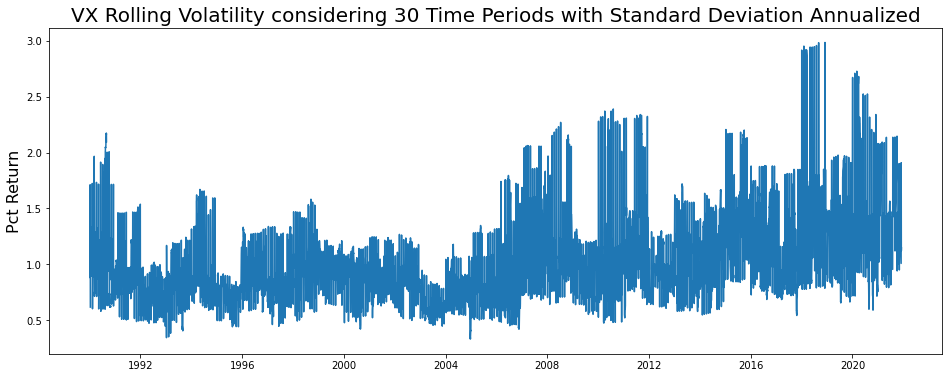

In [140]:
plt.figure(figsize=(16,6))
plt.plot(to_plt['Volatility'])
plt.ylabel('Pct Return', fontsize=16)
plt.title('VX Rolling Volatility considering 30 Time Periods with Standard Deviation Annualized', fontsize=20)

In [141]:
df=to_plt.dropna()

In [142]:
vol = df['Volatility'] * 100

### To Check if there is null value in any of the column

In [143]:
df.isnull().any() 

Open          False
High          False
Low           False
Close         False
Adj Close     False
Volume        False
log_price     False
pct_change    False
stdev         False
Volatility    False
dtype: bool

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7904 entries, 1990-01-03 to 2021-12-05
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        7904 non-null   float64
 1   High        7904 non-null   float64
 2   Low         7904 non-null   float64
 3   Close       7904 non-null   float64
 4   Adj Close   7904 non-null   float64
 5   Volume      7904 non-null   int64  
 6   log_price   7904 non-null   float64
 7   pct_change  7904 non-null   float64
 8   stdev       7904 non-null   float64
 9   Volatility  7904 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 679.2 KB


### Performing the ADF test to identify if the return series is stationary or non-stationary

In [145]:
result = adfuller(df.Volatility)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.631603
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


## Volatility Prediction using GARCH(3,1)

In [146]:
GARCH_Mod = arch_model(vol, vol='Garch', p=3, o=0, q=1, dist='Normal')

### GARCH Summary

In [147]:
res = GARCH_Mod.fit(disp='off')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             Volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -38027.9
Distribution:                  Normal   AIC:                           76067.8
Method:            Maximum Likelihood   BIC:                           76109.7
                                        No. Observations:                 7904
Date:                Mon, Nov 15 2021   Df Residuals:                     7903
Time:                        17:10:37   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            88.8885      0.975     91.129      0.000 [ 86.977, 90.800]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega        110.8320     42.483      2.609  9.084e-03 [ 27.567,1.941e+02]
alpha[1]       0.4793  5.057e-02      9.476  2.638e-21   [  0.380,  0.578]
alpha[2]   1.0561e-09      0.101  1.049e-08      1.000   [ -0.197,  0.197]
alpha[3]   2.7648e-10  8.964e-02  3.084e-09      1.000   [ -0.176,  0.176]
beta[1]        0.5048      0.175      2.890  3.856e-03   [  0.162,  0.847]
==========================================================================

Covariance estimator: robust
"""

### Creating Forecasted Volatility feature

In [148]:
df['forecast_vol'] = 0.1 * np.sqrt(res.params['omega'] + res.params['alpha[1]'] * res.resid**2 + res.conditional_volatility**2 * res.params['beta[1]'])

In [149]:
df['Volatility'].head(20)

Date
1990-01-03    0.893589
1990-01-05    1.334283
1990-01-06    0.881965
1990-01-08    1.712147
1990-01-10    0.947622
1990-01-11    0.618401
1990-02-03    0.895341
1990-02-04    1.017414
1990-02-05    1.335973
1990-02-07    1.268275
1990-02-08    1.723761
1990-02-10    0.943967
1990-02-11    0.603746
1990-02-13    1.072026
1990-02-14    1.091692
1990-02-15    1.133728
1990-02-16    1.136526
1990-02-20    1.166584
1990-02-21    1.144704
1990-02-22    1.157712
Name: Volatility, dtype: float64

In [150]:
pip install openpyxl

In [151]:
df['Volatility'].to_excel('g_a.xlsx')# to export actual value of GARCH MODEL

In [152]:
df['forecast_vol'].to_excel('g_p.xlsx')# to export predicted value of GARCH MODEL

### Ploting Actual Volatility Vs Forecasted Volatility

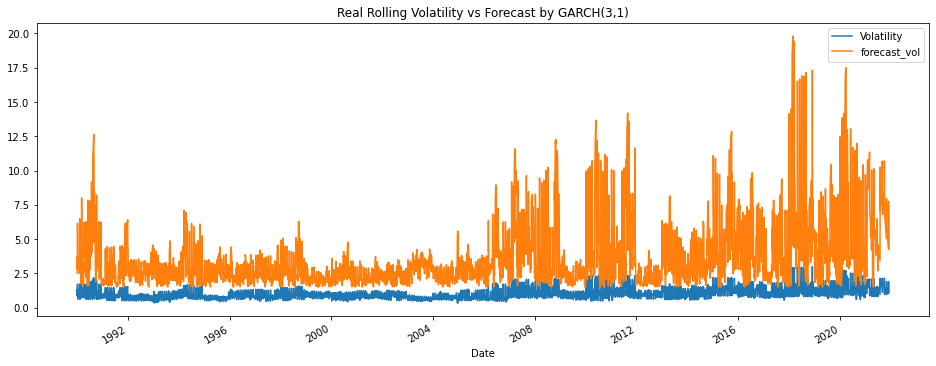

In [153]:
plt.figure(figsize=(16,6))
df["Volatility"].plot()
df["forecast_vol"].plot()
plt.title("Real Rolling Volatility vs Forecast by GARCH(3,1)")
plt.legend()
plt.show()

### Calculating RMSE value for GARCH Model

In [154]:
print('RMSE calculated for GARCH(3,1) model:', np.sqrt(metrics.mean_squared_error(df.loc[df.index[1000:], 'Volatility'], df.loc[df.index[1000:], 'forecast_vol'])))

RMSE calculated for GARCH(3,1) model: 3.235846319536613


## Volatility Prediction using LSTM

In [155]:
training_set = df.iloc[:, 9:10].values
X_train = []
y_train = []
for i in range(1000, df.shape[0]):
    X_train.append(training_set[i-1000:i,0])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Preparing X_train for RNN using LSTM

In [156]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### Ceating RNN with LSTM

In [157]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 10))
regressor.add(Dropout(0.1))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 1, batch_size = 32)

216/216 [==============================] - 312s 1s/step - loss: 0.1632


### Store the result of LSTM

In [158]:
regressor.save('Volatility_VI.h5')

In [159]:
regressor = load_model('Volatility_VI.h5')

In [160]:
#regressor.fit(disp='off')

### Creating Predicted Volatility feature

In [161]:
predicted_vol = regressor.predict(X_train)

In [162]:
p_d = pd.DataFrame(df.iloc[1000:, 9:10].values)

In [163]:
p_d.head(20)

,0
0,0.745976
1,0.782019
2,0.787545
3,0.811788
4,0.784194
5,1.313472
6,1.337333
7,0.753984
8,0.799705
9,0.701402


In [164]:
p_d.to_excel('lst_a.xlsx') #PRINT ACTUAL VALUE

In [165]:
p_d_2=pd.DataFrame(predicted_vol)

In [166]:
p_d_2.to_excel('lst_p.xlsx') #PRINT PREDICTED VALUE

In [167]:
#p_d_2.head(20)

In [168]:
#plt.scatter(p_d, p_d_2)
#plt.show()

### Ploting Volatility Real Rolling  vs LSTM Forecasted

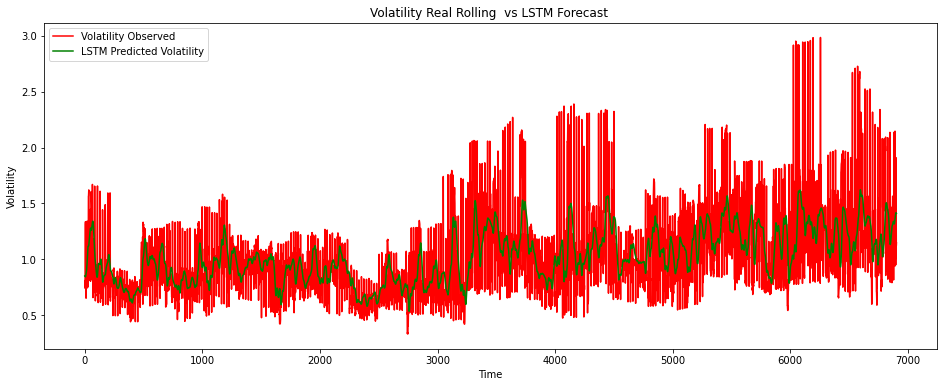

In [169]:
# Visualising the results
plt.figure(figsize=(16,6))
plt.plot(df.iloc[1000:, 9:10].values, color = 'red', label = 'Volatility Observed')
plt.plot(predicted_vol, color = 'green', label = 'LSTM Predicted Volatility')
plt.title('Volatility Real Rolling  vs LSTM Forecast ')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

### Calculating RMSE value for LSTM Model

In [170]:
print('RMSE calculated for LSTM model:', np.sqrt(metrics.mean_squared_error(df.iloc[1000:, 9:10].values, predicted_vol)))


RMSE calculated for LSTM model: 0.3108927727958982


## Volatility Prediction using Monte Carlo Simulation

In [171]:
returns_M = df['Volatility']

In [172]:
last_Close = df.Volatility[-1]

### Number of Simulations

In [173]:
num_simulations = 10
num_days = 252

In [174]:
simulation_df = pd.DataFrame()
for x in range(num_simulations):
    count = 0
    daily_vol = returns_M.std()
    
    price_series = []
    
    price = last_Close * (1 + np.random.normal(0, daily_vol))
    price_series.append(price)
    
    for y in range(num_days):
        if count == 251:
            break
        price = price_series[count] * (1 + np.random.normal(0, daily_vol))
        price_series.append(price)
        count += 1
    
    simulation_df[x] = price_series

In [175]:
MC_a=df['Volatility'].head(252)

In [176]:
MC_a.to_excel('MC_a.xlsx') # to export actual values of MC MODEL

In [177]:
simulation_df.to_excel('MC.xlsx') # FOR TOP 252 DAYS PREDICTED VALUE USING MC

### Ploting Monte Carlo Volatility

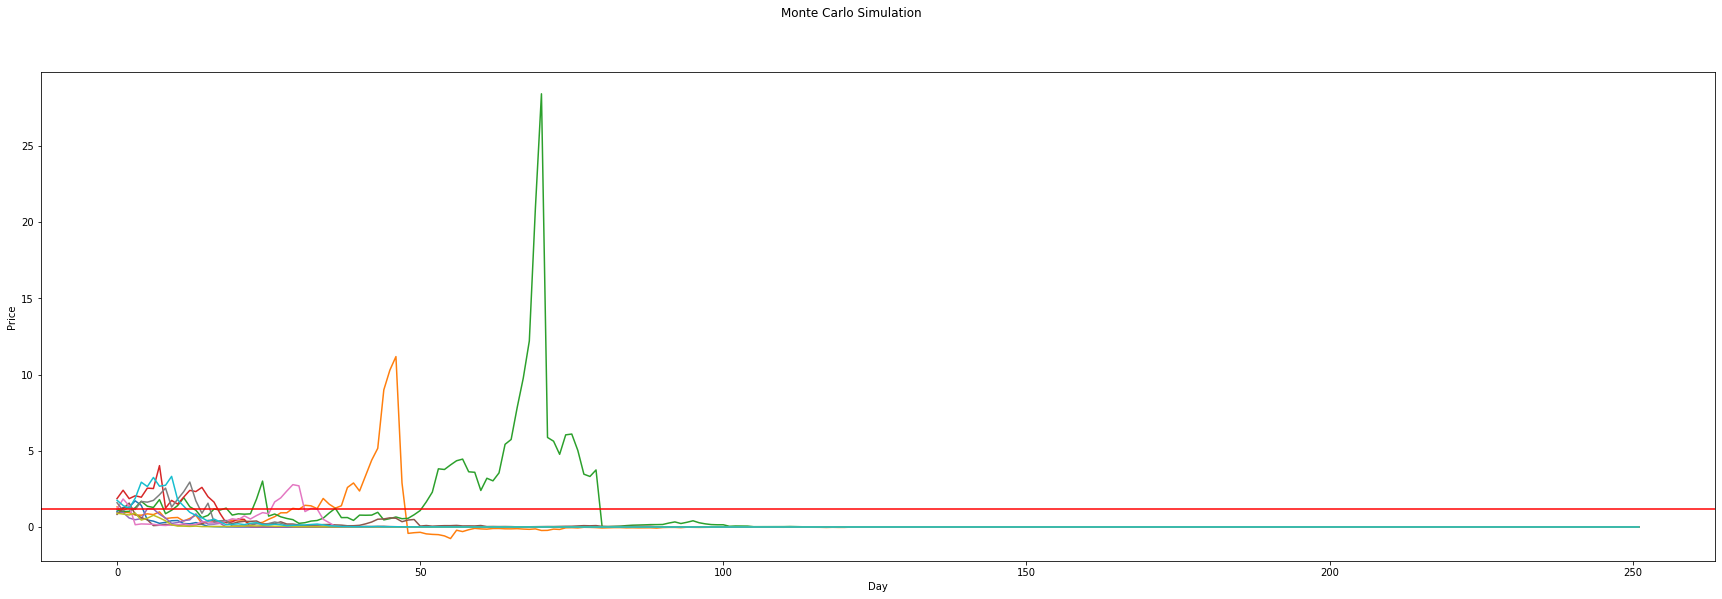

In [178]:
fig = plt.figure(figsize=(30,9))
fig.suptitle('Monte Carlo Simulation')
plt.plot(simulation_df)
plt.axhline(y = last_Close, color = 'r', linestyle = '-')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

## Volatility Prediction Using SVM

### Preparing testing and training dataset

In [179]:
training_set = df.iloc[:, 9:10].values
X_tr = []
y_tr = []
for i in range(10, df.shape[0]):
    X_tr.append(training_set[i-10:i,0])
    y_tr.append(training_set[i,0])
X_tr, y_tr = np.array(X_tr), np.array(y_tr)

#### RBF model

In [180]:
svr_rbf = SVR(kernel='rbf',C=10,gamma=10)

In [181]:
y_rbf = svr_rbf.fit(X_tr,y_tr).predict(X_tr)

In [182]:
predicted_vol_rbf = np.exp(y_rbf)

#### Linear model

In [183]:
svr_linear = SVR(kernel='linear',C=10)

In [184]:
y_linear = svr_linear.fit(X_tr,y_tr).predict(X_tr)

In [185]:
predicted_vol_linear = np.exp(y_linear)

In [186]:
p_d_s_o = pd.DataFrame(df.iloc[10:, 9:10].values)

In [187]:
p_d_s_R = pd.DataFrame(predicted_vol_rbf)

In [188]:
p_d_s_l = pd.DataFrame(predicted_vol_linear)

In [189]:
p_d_s_o = pd.DataFrame(df.iloc[10:, 9:10].values) # ACTUAL VALUES

In [190]:
p_d_s_o.to_excel('SVR_A.xlsx') # prints actual values

In [191]:
p_d_s_R.to_excel('SVR_r_p.xlsx') #PRINT RBF SVR VALUE FORECAST

In [192]:
p_d_s_l.to_excel('SVR_l_p.xlsx')#pRINT LINEAR SVR VALUE FORECAST

In [193]:
p_d_s_l.head(20)

,0
0,3.234199
1,4.346928
2,2.872254
3,2.324992
4,2.809662
5,2.898488
6,2.967233
7,2.939715
8,3.043895
9,3.087798


#### Polynomial Model

In [194]:
#svr_poly = SVR(kernel = 'poly',C=10)

In [195]:
#y_poly = svr_poly.fit(X_tr,y_tr).predict(X_tr)

In [196]:
#predicted_vol_poly = np.exp(y_poly)

### Ploting Volatility Observed, predicted Volatility using RBF,predicted Volatility using Linear SVR

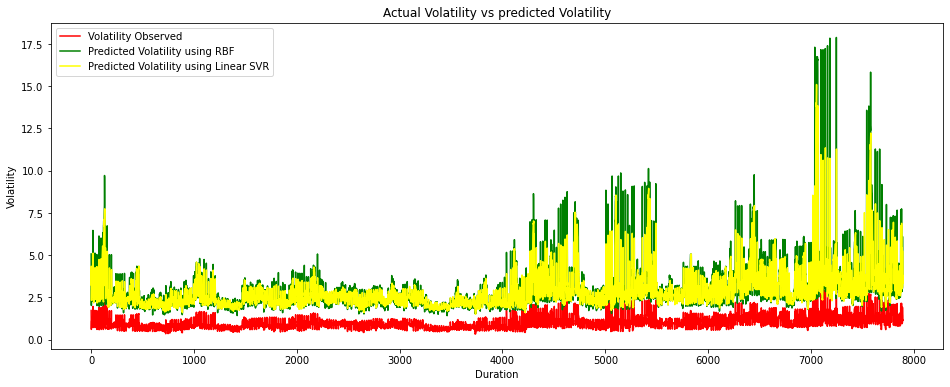

In [197]:
# Visualising the results
plt.figure(figsize=(16,6))
plt.plot(df.iloc[10:, 9:10].values, color = 'red', label = 'Volatility Observed')
plt.plot(predicted_vol_rbf, color = 'green', label = 'Predicted Volatility using RBF')
plt.plot(predicted_vol_linear, color = 'yellow', label = 'Predicted Volatility using Linear SVR')
#plt.plot(predicted_vol, color = 'green', label = 'LSTM Predicted Volatility')
plt.title('Actual Volatility vs predicted Volatility')
plt.xlabel('Duration')
plt.ylabel('Volatility')
plt.legend()
plt.show()

### Calculating RMSE value for SVM Model

In [198]:
print('RMSE calculated for SVM:', np.sqrt(metrics.mean_squared_error(df.iloc[10:, 9:10].values, predicted_vol_linear)))

RMSE calculated for SVM: 2.0727838834598478


## Volatility Prediction using Random Forest

#### Create Random Forest Regressor Model

In [199]:
ran_mod = RandomForestRegressor()

In [200]:
rand_mod = ran_mod.fit(X_tr, y_tr)

### Predicted Volatility

In [201]:
predicted_vol_rand = rand_mod.predict(X_tr)

In [202]:
p_d_For = pd.DataFrame(predicted_vol_rand)

In [203]:
p_d_For.to_excel('rand_For_p.xlsx')#PRINT PREDIICTED VALUE

In [204]:
p_d_s_o.to_excel('rand_For_a.xlsx')#PRINT ACTUAL VALUE

In [205]:
p_d_For.head(20)

,0
0,1.563261
1,0.972349
2,0.793927
3,1.059913
4,1.055184
5,1.171330
6,1.135188
7,1.149467
8,1.156441
9,1.111097


### Ploting Volatility Observed, predicted Volatility using Random Forest

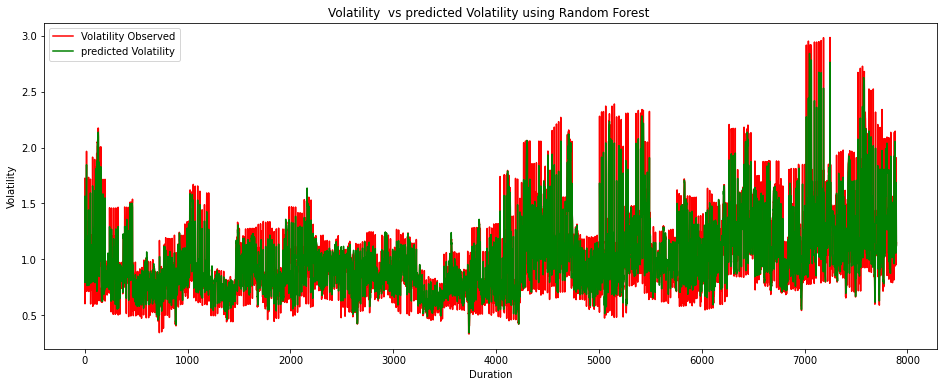

In [206]:
# Visualising the results
plt.figure(figsize=(16,6))
plt.plot(df.iloc[10:, 9:10].values, color = 'red', label = 'Volatility Observed')
plt.plot(predicted_vol_rand, color = 'green', label = 'predicted Volatility')
plt.title('Volatility  vs predicted Volatility using Random Forest ')
plt.xlabel('Duration')
plt.ylabel('Volatility')
plt.legend()
plt.show()

### Calculating RMSE value for Random Forest Model

In [207]:
print('RMSE calculated for Random Forest:', np.sqrt(metrics.mean_squared_error(df.iloc[10:, 9:10].values, predicted_vol_rand)))

RMSE calculated for Random Forest: 0.08883566331451562
